In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
#Connect sqlite db
con = sqlite3.connect("D:/Data_Practice/database.sqlite")

filtered_data = pd.read_sql_query('''SELECT * FROM Reviews WHERE Score!=3''',con)
filtered_data.head()


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(UserId)
FROM Reviews
GROUP BY UserId
HAVING COUNT(UserId)>1
""", con)
display.head()


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(UserId)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
filtered_data[filtered_data['UserId']=='#oc-R11D9D7SHXIJB9']

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
268373,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
421207,455534,B005HG9ERW,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."
459536,496894,B005HG9ET0,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u..."


In [7]:
#Now we replace rating by Pos/Neg in Score column
def replace(x):
    if x<3:
        return 'Negative'
    return 'Positive'
Scores = filtered_data['Score']
PosNeg = Scores.map(replace)
filtered_data['Score'] = PosNeg
filtered_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [8]:
filtered_data.shape

(525814, 10)

In [9]:
#Deduplication
sorted_data = filtered_data.sort_values('ProductId',axis=0,ascending=True)#Sorted by ProductId ascending
final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first',inplace=False)#We remove extras when those four are same for rows and keep first
final.shape #(364173, 10) 30% waste data gone

(364173, 10)

In [10]:
final = final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
final.shape #2 rows gone

(364171, 10)

In [11]:
final['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [17]:
#BagofWords
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
final_bow = count_vect.fit_transform(final['Text'].values)
final_bow.shape #(364171, 115281) -- 115k unique words
#print(final_bow) -- gives sparse matrix rep (row,col,val(num of times word exist in that review))
#print(count_vect.get_feature_names()) #all unique words

(364171, 115281)

In [15]:
#Text preprocessing
#Init stop words and stemming
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english'))
snostem = nltk.stem.SnowballStemmer('english')

print(snostem.stem('beautiful'))

beauti


In [4]:
#re html tags and punc funcs
def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr,' ',sentence)
    return cleantext
#sentence = 'I am <> Om'
#cleanhtml(sentence)

In [5]:
#func for removing punctuations
import re
def cleanpunc(sentence):
    cleaned = re.sub('[?|!|\'|"|#]',' ',sentence)
    cleaned = re.sub('[.|,|(|)|\|/]',' ',cleaned)
    return cleaned
sentence = 'I am?(Om'
cleanpunc(sentence)

'I am  Om'

In [21]:
#Total processing
def text_preprocessing(final): 
    i=0
    str=''
    final_string=[]
    all_pos_words=[]
    all_neg_words=[]
    s=''
    for sent in final['Text'].values:
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split(): #after cleanpunc again one word may become two or multiple so they'll be split and stored as different words
                if((cleaned_words.isalpha()&(len(cleaned_words)>2))):
                    if(cleaned_words.lower() not in stop):
                        s = (snostem.stem(cleaned_words.lower()).encode('utf8'))
                        filtered_sentence.append(s)
                        if(final['Score'].values)[i] == 'Positive':
                            all_pos_words.append(s)
                        if(final['Score'].values)[i] == 'Negative':
                            all_neg_words.append(s)
        str = b" ".join(filtered_sentence)
        final_string.append(str)
        i+=1
    return final_string

final_text = []
final_text = text_preprocessing(final)



In [22]:
final_text[:100]

[b'witti littl book make son laugh loud recit car drive along alway sing refrain learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg',
 b'grew read sendak book watch realli rosi movi incorpor love son love howev miss hard cover version paperback seem kind flimsi take two hand keep page open',
 b'fun way children learn month year learn poem throughout school year like handmot invent poem',
 b'great littl book read nice rhythm well good repetit littl one like line chicken soup rice child get month year wonder place like bombay nile eat well know get eat kid mauric sendak version ice skate treat rose head long time even know came surpris came littl witti book',
 b'book poetri month year goe month cute littl poem along love book realli fun way learn month poem creativ author purpos write book give children fun way learn month children also learn thing poetri rhythm read book',
 b'charm rhyme book describ circumst eat chicken sou

In [23]:
#We add extra col to final df with prepro text data
final['Cleaned_Text'] = final_text

In [26]:
final['Text'][138692]

'TITLE: Chicken Soup with Rice<br />AUTHOR: Maurice Sendak<br />REVIEWER: Josh Grossman, Colonel {r}, U.S.A.R., M.C., M.D., FACP<br />Rural physician/author/educator-Mentor U.S.M.L.E. Step 3...<br />>Who would believe that I have memorized this book?<br />>Who would believe that I can recite any month in any order?<br />>Who would believe that I read my copy to tatters while reading to my children now professional adults?<br />>Who would believe that my grandchildren read their copy to tatters?<br />I can be confident that generations of children will enjoy "Chicken Soup with Rice"<br />Bravo!<br />Thank you!<br />Respectfully submitted...'

In [25]:
final['Cleaned_Text'][138692]

b'chicken soup rice mauric sendak josh grossman colonel facp rural physician author step would believ memor book would believ recit month order would believ read copi tatter read children profession adult would believ grandchildren read copi tatter confid generat children enjoy chicken soup rice bravo thank respect submit'

In [27]:
#final tbl to sqlite db
conn=sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory=str
final.to_sql('Reviews',conn,if_exists='replace')

In [28]:
count_vect = CountVectorizer(ngram_range=(1,2))
final_bow = count_vect.fit_transform(final['Cleaned_Text'].values)
final_bow.get_shape()

(364171, 2885241)

In [3]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
con = sqlite3.connect("D:/Data_Practice/final.sqlite")

final = pd.read_sql_query('''SELECT * FROM Reviews''',con)
final.shape
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,Positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,Positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,Positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,Positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,Positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


In [7]:
#Bigrams,ngrams
from sklearn.feature_extraction.text import CountVectorizer
count_vect_bi = CountVectorizer(ngram_range=(1,2))#Uni(1) and Bi grams(2)
final_uni_bi  = count_vect_bi.fit_transform(processed_data['Cleaned_Text'].values)
final_uni_bi.get_shape() #(364171, 2885241) we can see massive incr in unique words 115k to 2.9M from uni to uni+bi

(364171, 2885241)

In [30]:
#print(final_uni_bi)
#sparse mat rep
print(count_vect_bi.get_feature_names()[:10000])#We can see uni and bi grams here

['aa', 'aa pleas', 'aaa', 'aaa aaa', 'aaa class', 'aaa condit', 'aaa hockey', 'aaa job', 'aaa magazin', 'aaa perfect', 'aaa plus', 'aaa rate', 'aaa spelt', 'aaa think', 'aaa tue', 'aaaa', 'aaaaa', 'aaaaa kid', 'aaaaa start', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaa hahahahhahahaahhahaaha', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa serious', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaargh wait', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaah good', 'aaaaaaahhhhhh', 'aaaaaaahhhhhh raspberri', 'aaaaaaarrrrrggghhh', 'aaaaaaarrrrrggghhh back', 'aaaaaah', 'aaaaaah melt', 'aaaaaahhh', 'aaaaaahhh help', 'aaaaaahhhh', 'aaaaaahhhh ten', 'aaaaaahhhhh', 'aaaaaahhhhh leav', 'aaaaaahhhhhyaaaaaa', 'aaaaaahhhhhyaaaaaa fire', 'aaaaaand', 'aaaaaand kid', 'aaaaaawwwwwwwwww', 'aaaaaawwwwwwwwww depart', 'aaaaah', 'aaaaah awak', 'aaaaah satisfi', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaahhhhhhhhhhhhhhhh angel', 'aaaaallll', 'aaaaallll acn', 'aaaaawsom', 'aaaaawsom chump', 'aaa

In [31]:
type(final_uni_bi)

scipy.sparse.csr.csr_matrix

In [32]:
#tfidf
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tfidf = tfidf_vect.fit_transform(processed_data['Cleaned_Text'].values)#list_of_sent

In [34]:
print(tfidf_vect.get_feature_names()[:10000])#same as bigrms names

['aa', 'aa pleas', 'aaa', 'aaa aaa', 'aaa class', 'aaa condit', 'aaa hockey', 'aaa job', 'aaa magazin', 'aaa perfect', 'aaa plus', 'aaa rate', 'aaa spelt', 'aaa think', 'aaa tue', 'aaaa', 'aaaaa', 'aaaaa kid', 'aaaaa start', 'aaaaaaaaaaaaaa', 'aaaaaaaaaaaaaa hahahahhahahaahhahaaha', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa', 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa serious', 'aaaaaaaaaaaaaaaaaaaargh', 'aaaaaaaaaaaaaaaaaaaargh wait', 'aaaaaaaaagghh', 'aaaaaaah', 'aaaaaaah good', 'aaaaaaahhhhhh', 'aaaaaaahhhhhh raspberri', 'aaaaaaarrrrrggghhh', 'aaaaaaarrrrrggghhh back', 'aaaaaah', 'aaaaaah melt', 'aaaaaahhh', 'aaaaaahhh help', 'aaaaaahhhh', 'aaaaaahhhh ten', 'aaaaaahhhhh', 'aaaaaahhhhh leav', 'aaaaaahhhhhyaaaaaa', 'aaaaaahhhhhyaaaaaa fire', 'aaaaaand', 'aaaaaand kid', 'aaaaaawwwwwwwwww', 'aaaaaawwwwwwwwww depart', 'aaaaah', 'aaaaah awak', 'aaaaah satisfi', 'aaaaahhhhhhhhhhhhhhhh', 'aaaaahhhhhhhhhhhhhhhh angel', 'aaaaallll', 'aaaaallll acn', 'aaaaawsom', 'aaaaawsom chump', 'aaa

In [35]:
print(len(tfidf_vect.get_feature_names()))

2885241


In [41]:
print(final_tfidf[0,1568373]) #If we give row(364k),column(2.9M) it gives us the tfidf value of that row,col

0.1492787856400532


In [42]:
type(final_tfidf)

scipy.sparse.csr.csr_matrix

In [43]:
print(final_tfidf)#tfidf vals in sparse matrix

  (0, 1568373)	0.1492787856400532
  (0, 2057181)	0.15404217888766006
  (0, 1733)	0.15404217888766006
  (0, 2418508)	0.10546235275657513
  (0, 2346484)	0.12587176934438293
  (0, 229903)	0.15404217888766006
  (0, 2819635)	0.12436998631424716
  (0, 275996)	0.15404217888766006
  (0, 477517)	0.15404217888766006
  (0, 2275424)	0.15404217888766006
  (0, 1308283)	0.15404217888766006
  (0, 275578)	0.1458991043457289
  (0, 2837267)	0.1492787856400532
  (0, 1680353)	0.1377560298037977
  (0, 1488241)	0.09866194405039674
  (0, 766664)	0.15404217888766006
  (0, 1275994)	0.15404217888766006
  (0, 2804105)	0.15404217888766006
  (0, 1404839)	0.15404217888766006
  (0, 2068789)	0.15404217888766006
  (0, 2284975)	0.15404217888766006
  (0, 77802)	0.15404217888766006
  (0, 63025)	0.1458991043457289
  (0, 765357)	0.13932475303361877
  (0, 381482)	0.1289007388259159
  :	:
  (364170, 909933)	0.10776854151001325
  (364170, 1168844)	0.14076999538297486
  (364170, 1488143)	0.10097700824275431
  (364170, 908916)	0

In [19]:
pip install bs4 

  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1279 sha256=01b3e74547feaf9d7bd12c35c7ac6d34075aee2604886dfd43ba43320940c32b
  Stored in directory: c:\users\kiran\appdata\local\pip\cache\wheels\19\f5\6d\a97dd4f22376d4472d5f4c76c7646876052ff3166b3cf71050
Successfully built bs4
Note: you may need to restart the kernel to use updated packages.


In [1]:
#Word2Vec
#Google model
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('D:/Data_Practice/GoogleNews-vectors-negative300.bin',binary=True)

In [2]:
model.similarity('man','woman')#wv is not needed

0.76640123

In [74]:
model.most_similar('man')#wv is not needed

[('woman', 0.7664012312889099),
 ('boy', 0.6824870109558105),
 ('teenager', 0.6586930751800537),
 ('teenage_girl', 0.6147903203964233),
 ('girl', 0.5921714305877686),
 ('suspected_purse_snatcher', 0.571636438369751),
 ('robber', 0.5585119128227234),
 ('Robbery_suspect', 0.5584409236907959),
 ('teen_ager', 0.5549196004867554),
 ('men', 0.5489763021469116)]

In [75]:
model['man'] #wv is not needed #Vector(Dense) 300D

array([ 0.32617188,  0.13085938,  0.03466797, -0.08300781,  0.08984375,
       -0.04125977, -0.19824219,  0.00689697,  0.14355469,  0.0019455 ,
        0.02880859, -0.25      , -0.08398438, -0.15136719, -0.10205078,
        0.04077148, -0.09765625,  0.05932617,  0.02978516, -0.10058594,
       -0.13085938,  0.001297  ,  0.02612305, -0.27148438,  0.06396484,
       -0.19140625, -0.078125  ,  0.25976562,  0.375     , -0.04541016,
        0.16210938,  0.13671875, -0.06396484, -0.02062988, -0.09667969,
        0.25390625,  0.24804688, -0.12695312,  0.07177734,  0.3203125 ,
        0.03149414, -0.03857422,  0.21191406, -0.00811768,  0.22265625,
       -0.13476562, -0.07617188,  0.01049805, -0.05175781,  0.03808594,
       -0.13378906,  0.125     ,  0.0559082 , -0.18261719,  0.08154297,
       -0.08447266, -0.07763672, -0.04345703,  0.08105469, -0.01092529,
        0.17480469,  0.30664062, -0.04321289, -0.01416016,  0.09082031,
       -0.00927734, -0.03442383, -0.11523438,  0.12451172, -0.02

In [20]:
from bs4 import BeautifulSoup
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [28]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [49]:
# Combining all the above stundents 
from tqdm import tqdm
list_of_sent = []
f_sentence=[]
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = cleanhtml(sentance)
    sentance = re.sub(r"http\S+", "", sentance)
    #sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)

    # https://gist.github.com/sebleier/554280
    list_of_sent.append(sentance)

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:38<00:00, 9364.42it/s]


In [6]:
import gensim
from tqdm import tqdm
list_of_sent=[]
for sent in tqdm(final['Text'].values):
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue
    list_of_sent.append(filtered_sentence)


100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [01:03<00:00, 5752.33it/s]


In [68]:
list_of_sent#All words in first text 

[['this',
  'witty',
  'little',
  'book',
  'makes',
  'my',
  'son',
  'laugh',
  'at',
  'loud',
  'i',
  'recite',
  'it',
  'in',
  'the',
  'car',
  'as',
  'we',
  're',
  'driving',
  'along',
  'and',
  'he',
  'always',
  'can',
  'sing',
  'the',
  'refrain',
  'he',
  's',
  'learned',
  'about',
  'whales',
  'india',
  'drooping',
  'i',
  'love',
  'all',
  'the',
  'new',
  'words',
  'this',
  'book',
  'introduces',
  'and',
  'the',
  'silliness',
  'of',
  'it',
  'all',
  'this',
  'is',
  'a',
  'classic',
  'book',
  'i',
  'am',
  'willing',
  'to',
  'bet',
  'my',
  'son',
  'will',
  'still',
  'be',
  'able',
  'to',
  'recite',
  'from',
  'memory',
  'when',
  'he',
  'is',
  'in',
  'college'],
 ['i',
  'grew',
  'up',
  'reading',
  'these',
  'sendak',
  'books',
  'and',
  'watching',
  'the',
  'really',
  'rosie',
  'movie',
  'that',
  'incorporates',
  'them',
  'and',
  'love',
  'them',
  'my',
  'son',
  'loves',
  'them',
  'too',
  'i',
  'do'

In [7]:
#Now we train our own model
w2v_model = gensim.models.Word2Vec(tqdm(list_of_sent),min_count=3,size=200,workers=4)

100%|███████████████████████████████████████████████████████████████████████| 364171/364171 [00:03<00:00, 92579.41it/s]


In [13]:
w2v_model.similarity('man','woman') #Output is diff from google model as it is from our final dataset

C:\Users\kiran\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.56277573

In [14]:
w2v_model.wv.most_similar('man') #Output is diff from google model as it is from our final dataset

[('dude', 0.6115472912788391),
 ('guy', 0.5911980867385864),
 ('boy', 0.5762944221496582),
 ('woman', 0.562775731086731),
 ('keaton', 0.508980929851532),
 ('gosh', 0.5023015737533569),
 ('uh', 0.49564555287361145),
 ('lord', 0.47658249735832214),
 ('gee', 0.4680217504501343),
 ('god', 0.46184131503105164)]

In [23]:
words = list(w2v_model.wv.vocab)
len(words) #33294 unique words

33294

In [123]:
#Avg w2v 
avg_w2v = []
for sent in tqdm(list_of_sent):
    avg_w2v_ = np.zeros(50)
    cnt=1
    for w in sent:
        try:
            vec = w2v_model.wv[w]
            avg_w2v_ = avg_w2v_ + vec
            cnt+=1
        except:
            pass
    avg_w2v_=avg_w2v_/cnt
    avg_w2v.append(avg_w2v_)

    

  0%|                                                                                       | 0/364171 [00:00<?, ?it/s]C:\Users\kiran\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [03:48<00:00, 1594.91it/s]


In [15]:
print(len(avg_w2v[1])) #Every pt has 50 dim
print(avg_w2v[:1])

NameError: name 'avg_w2v' is not defined

In [200]:
print(type(avg_w2v))

<class 'list'>


In [107]:
tfidf_features = tfidf_vect.get_feature_names()
tfidf_vectors=[]
row=0
for sent in list_of_sent[:10]:
    tfidf_vec = np.zeros(50)
    weighsum = 0
    for word in sent:
        try:
            vec = w2v_model.wv[word]
            tfidf = final_tfidf[row,tfidf_features.index(word)]
            tfidf_vec += (tfidf*vec)
            weighsum += tfidf
        except:
            pass
    tfidf_vec = tfidf_vec/weighsum
    tfidf_vectors.append(tfidf_vec)
    row+=1
print(len(tfidf_vectors))
print(tfidf_vectors[0])

10
[ 0.59774769  0.54537125  0.62324004  0.02041944  0.02257409 -0.30200503
 -0.63326441 -1.29674766  0.30734551 -0.22142203 -0.44125643  0.18112113
 -0.42649258  0.18969578  0.2241953   0.68756171  0.46647666 -0.07080633
  0.18189327  0.55210904  0.35037138 -0.04579876 -0.2597203  -0.24284169
 -1.02358136 -0.33087114 -1.4748507  -0.23858488  0.78737667  0.92884899
 -0.50669438 -0.06888837  0.87920902  0.49174217 -0.22622327  0.73049026
 -0.28244415 -0.11653063  0.37210911  0.23779732  0.93955605 -0.45240591
  0.63180835  0.15507515  0.16526986  0.36514653 -0.44407539 -0.69257367
 -0.00317432  0.63587368]


In [133]:
final_bowd = final_bow[0:1000,0:115281]
final_bow_1000=final_bowd.todense()
i=0
for i in range(0,1000):
    for j in range(0,115281):
        if(final_bow_1000[i,j]!=0):
            print(i,j,final_bow_1000[i,j])
    i=i+1

0 5093 1
0 5150 1
0 7296 2
0 7529 1
0 7734 1
0 7750 1
0 8302 2
0 9973 1
0 10401 1
0 19419 1
0 20386 1
0 22082 3
0 24971 1
0 25403 1
0 28971 1
0 29981 1
0 39477 1
0 39520 1
0 47909 1
0 53557 3
0 57052 2
0 57417 1
0 58762 1
0 59142 2
0 59284 2
0 63059 1
0 63308 1
0 64507 1
0 65167 1
0 65217 1
0 66253 1
0 68341 1
0 71724 2
0 72824 1
0 74846 1
0 85813 1
0 86314 2
0 86908 1
0 89722 1
0 94431 1
0 94619 1
0 96473 2
0 98814 1
0 103373 4
0 103749 3
0 104542 2
0 111527 1
0 111991 1
0 112121 1
0 112630 1
0 112660 1
0 113004 1
0 113360 1
1 8302 3
1 22104 1
1 32660 1
1 38548 1
1 46326 1
1 51585 1
1 52923 1
1 53094 1
1 55547 1
1 57291 1
1 59284 1
1 61054 1
1 61515 1
1 65217 1
1 65253 1
1 69720 1
1 71036 1
1 71724 1
1 74846 1
1 75602 1
1 77247 1
1 77662 1
1 85871 1
1 85950 1
1 89733 1
1 92467 1
1 92695 1
1 96473 1
1 101824 1
1 103344 1
1 103373 4
1 103443 3
1 103573 1
1 104542 1
1 104868 1
1 106779 1
1 108668 1
1 109908 1
1 111363 1
2 7296 1
2 27739 1
2 40078 1
2 46897 2
2 48329 1
2 52916 1
2 58830 1

19 104542 1
19 109908 1
19 111267 1
19 113680 1
20 5455 1
20 7296 1
20 8185 1
20 8302 1
20 9526 1
20 9973 2
20 19669 1
20 19793 1
20 22082 1
20 22104 1
20 22547 1
20 22595 11
20 22701 1
20 24133 1
20 25598 1
20 25843 1
20 27092 1
20 27096 1
20 27648 2
20 27739 1
20 37015 1
20 39518 1
20 46897 1
20 48398 1
20 50620 1
20 51410 1
20 51871 1
20 54632 1
20 56389 1
20 57052 1
20 59142 1
20 59200 1
20 59284 1
20 60535 1
20 64055 1
20 64507 1
20 66240 1
20 70536 1
20 72367 1
20 74846 5
20 75337 1
20 75782 1
20 76248 1
20 78932 1
20 79903 1
20 80074 1
20 80126 1
20 85855 1
20 87813 1
20 88874 1
20 89722 1
20 91312 1
20 92695 1
20 96374 1
20 96743 2
20 97704 3
20 98814 1
20 99088 1
20 102514 1
20 103373 7
20 103443 1
20 103690 1
20 103749 2
20 104542 2
20 106682 1
20 108004 1
20 108668 1
20 112133 1
20 112349 1
20 112587 1
20 112937 3
20 114175 1
21 1988 1
21 8302 1
21 19523 1
21 22082 1
21 24971 2
21 27739 1
21 28971 1
21 50378 1
21 59284 2
21 61397 1
21 62999 1
21 75866 1
21 85855 1
21 103344 

34 20356 1
34 22342 1
34 22520 1
34 24327 1
34 24832 1
34 30056 1
34 30066 1
34 30074 1
34 31529 2
34 39420 1
34 40810 1
34 42999 1
34 44628 2
34 46158 1
34 46175 1
34 46792 1
34 48048 2
34 51410 1
34 57052 1
34 59142 1
34 60585 2
34 69851 2
34 72205 2
34 73256 1
34 75414 1
34 75782 1
34 77045 1
34 77169 2
34 77174 1
34 79010 1
34 83207 1
34 84327 1
34 85897 1
34 98716 1
34 101250 1
34 102282 1
34 103311 1
34 103373 2
34 103516 1
34 103749 1
34 109563 1
34 111371 1
34 112937 2
34 114517 1
34 114561 1
35 8302 2
35 10515 1
35 19866 1
35 27807 1
35 38675 1
35 57052 2
35 59284 1
35 60585 1
35 65217 1
35 65961 1
35 67842 1
35 76338 1
35 79493 1
35 87039 1
35 90414 1
35 91120 1
35 91312 1
35 99067 1
35 101726 1
35 103344 1
35 103443 3
35 103602 1
35 111267 1
35 111869 1
36 8850 2
36 8869 1
36 9526 1
36 18450 1
36 19419 1
36 19604 1
36 24133 4
36 24280 1
36 26931 1
36 27648 2
36 27807 2
36 38675 1
36 45603 1
36 47909 1
36 50494 1
36 50620 1
36 53094 1
36 56944 1
36 57052 1
36 59142 1
36 59203

52 7607 1
52 8302 4
52 9526 1
52 9973 2
52 10401 1
52 24761 1
52 27416 1
52 30243 1
52 34086 1
52 38548 1
52 38675 1
52 38812 2
52 39284 1
52 40415 1
52 44221 2
52 45519 1
52 45603 1
52 46897 1
52 49514 1
52 49917 1
52 59075 1
52 59142 2
52 59284 1
52 60585 1
52 62899 1
52 62902 1
52 64649 1
52 65217 2
52 66253 1
52 70654 1
52 71174 2
52 73670 3
52 74846 2
52 75337 1
52 75354 1
52 76338 1
52 78366 1
52 80096 2
52 82636 1
52 83207 1
52 83591 1
52 86244 1
52 93696 1
52 94821 1
52 100876 1
52 103344 2
52 103373 6
52 103443 2
52 103573 1
52 103749 1
52 104542 2
52 104868 1
52 105431 1
52 105714 1
52 106779 1
52 108668 1
52 109946 1
52 111152 1
52 111527 2
52 112121 1
52 112937 1
52 114517 2
53 6171 1
53 7502 1
53 7607 1
53 8302 1
53 8483 1
53 19775 1
53 24327 1
53 24886 1
53 38675 1
53 46897 2
53 49495 1
53 54152 1
53 59142 1
53 59260 1
53 59284 1
53 65217 1
53 70532 1
53 71724 2
53 74846 1
53 75414 1
53 76338 1
53 83207 1
53 86017 1
53 86421 1
53 91266 1
53 93689 1
53 93696 1
53 95366 1
5

64 103443 1
64 103525 1
64 103573 1
64 103602 1
64 103749 1
64 103941 1
64 104542 1
64 105431 1
64 105699 3
64 105714 3
64 108903 2
64 111527 1
64 112133 1
64 112174 1
64 113512 1
64 114175 1
65 8891 1
65 19419 1
65 22595 1
65 25609 1
65 38548 1
65 38675 1
65 46897 1
65 49917 1
65 50462 1
65 64507 1
65 64537 1
65 64877 1
65 65217 1
65 71724 1
65 88896 1
65 96984 1
65 99536 1
65 103602 1
65 103749 1
65 105714 1
65 109946 2
65 111484 1
65 112630 1
66 6423 1
66 7734 1
66 8302 2
66 9526 2
66 23607 1
66 24042 1
66 33716 1
66 38675 1
66 39387 1
66 41883 1
66 47585 1
66 47674 1
66 49964 1
66 59284 2
66 62893 1
66 64507 1
66 65217 1
66 66240 1
66 66253 1
66 73256 1
66 74846 1
66 77148 1
66 77157 1
66 78884 1
66 85950 1
66 86213 1
66 90417 1
66 94591 1
66 103344 2
66 103573 2
66 103602 2
66 103749 1
66 104259 1
66 105699 1
66 105714 1
66 109946 1
66 113188 1
67 8302 1
67 10401 1
67 24280 1
67 34857 1
67 38675 1
67 39025 1
67 47909 1
67 51410 2
67 65217 1
67 71724 1
67 82825 1
67 92981 1
67 1033

86 31519 1
86 38675 1
86 39387 1
86 46897 1
86 47585 1
86 50620 1
86 59142 1
86 60585 1
86 64537 1
86 65217 1
86 82825 1
86 94821 1
86 103749 2
87 8302 1
87 27311 1
87 27648 1
87 38675 1
87 40250 1
87 43080 1
87 53557 1
87 55390 1
87 57208 1
87 59142 1
87 75354 1
87 75414 1
87 103373 1
87 103749 1
87 105908 1
87 111527 1
87 112630 1
88 7607 1
88 7855 1
88 9973 1
88 19820 1
88 24086 1
88 38632 1
88 38702 1
88 43042 1
88 44669 1
88 46897 1
88 49495 1
88 54100 2
88 57052 1
88 59284 1
88 61894 1
88 64507 1
88 65253 1
88 66415 1
88 71724 1
88 75331 1
88 77233 1
88 83207 2
88 86213 1
88 87261 1
88 88727 1
88 93404 2
88 103321 1
88 103373 2
88 103749 1
88 104247 1
88 104259 1
88 104542 2
88 111647 2
88 112630 1
88 113405 1
89 6801 1
89 7607 1
89 7855 1
89 8185 1
89 8302 3
89 8850 1
89 9526 2
89 10560 1
89 14300 1
89 19490 1
89 20647 1
89 22054 1
89 22595 2
89 23881 1
89 24355 1
89 27075 1
89 30120 1
89 30145 1
89 30300 1
89 32864 1
89 38632 5
89 38675 1
89 42999 1
89 43250 1
89 44102 1
89 442

KeyboardInterrupt: 

In [137]:
final_bow_1000[0,22082] #We are ready with 1000 rows and 115k cols/features
type(final_bow_1000)

numpy.matrix

In [144]:
from sklearn.preprocessing import StandardScaler
import seaborn as sb
stn_bow = StandardScaler().fit_transform(final_bow_1000)
stn_bow.shape


(1000, 115281)

In [145]:
type(stn_bow)

numpy.ndarray

In [149]:
score_l = final['Score'][0:1000]
score_l.value_counts()

Positive    831
Negative    169
Name: Score, dtype: int64

In [89]:
final_pos = final[final.Score=='Positive']
final_pos.shape

NameError: name 'final' is not defined

In [152]:
final_neg = final[final.Score=='Negative']
final_neg.shape
type(final_neg)

pandas.core.frame.DataFrame

In [159]:
final_pos_1000 = final_pos[0:1000]
final_pos_1000.shape
print(final_pos_1000.head(5))

            Id   ProductId          UserId                  ProfileName  \
138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

        HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
138706                     0                       0  Positive   939340800   
138688                     1                       1  Positive  1194739200   
138689                     1                       1  Positive  1191456000   
138690                     1                       1  Positive  1076025600   
138691                     3                       4  Positive  1018396800   

                                           Summary  \
138706                   E

In [173]:
final_neg_1000 = final_neg[0:1000]
final_neg_1000.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,Negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,Negative,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,b'give five star mauric sendak stori one star ...
22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,Negative,1192060800,made in china,My dogs loves this chicken but its a product f...,b'dog love chicken product china wont buy anym...
157869,171180,7310172001,A2WDF9UM0M1VAD,susan m. kaitz,3,6,Negative,1317859200,Review of Freeze Dried Liver Treats For Dogs,I received all containers previously opened - ...,b'receiv contain previous open seal open top c...
157873,171186,7310172001,A12OC9ZA779927,"Nancy Watts ""Nan Watts""",1,22,Negative,1134172800,no shipping charges in December if over $50 on...,Same price as Dr. Foster & Smith.,b'price foster smith'


In [176]:
final_2000 = pd.concat([final_pos_1000 , final_neg_1000],axis=0,ignore_index=True)
final_2000.tail()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text
1995,463849,B0000SXEKA,A2801SG8XA9LNX,PACW,7,8,Negative,1069113600,Ohhh ick!,"This frosting is sweet, and it is low in calor...",b'frost sweet low calori whenev come across te...
1996,463848,B0000SXEKA,A2C0712DLYODP5,M. Driscoll,9,9,Negative,1166572800,Maltodextrin impacts blood sugar!,Please note that Sweet 'n Low sugar free frost...,b'pleas note sweet low sugar free frost sugar ...
1997,41705,B0000SXEMI,A2RFYOQPWQS1A9,"N. J. Pederick ""greenrosestormcloud""",0,0,Negative,1245801600,disapointing!,i was looking forward o trying this product......,b'look forward tri product tast realli chemic ...
1998,41700,B0000SXEMI,A2FZZIQLF48ZAS,Robert Cooper,2,3,Negative,1207526400,Tasted a bit artificial and too pungent.,Didn't taste at all natural like a real key li...,b'tast natur like real key lime pie recommend ...
1999,402193,B0000SXENM,A2SY5Q718M72SN,tonytina27,1,1,Negative,1315872000,awful,This stuff is just awful. You can't even tell ...,b'stuff aw even tell suppos lemon flavor fact ...


In [195]:
final_2000_BoW = tfidf_vect.fit_transform(final_2000['Cleaned_Text'].values)
type(final_2000_BoW)
final_2000_BoW.get_shape()

(2000, 73562)

In [196]:
score_2000 = final_2000['Score']
score_2000.value_counts()
score_2000.shape

(2000,)

In [202]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2,random_state=0)
tsne_data = model.fit_transform(final_2000_BoW)
tsne_data.shape

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [198]:
tsne_label = np.vstack((tsne_data.T,score_2000)).T
tsne_label[:10]
#type(tsne_label)

array([[20.011457443237305, -26.376834869384766, 'Positive'],
       [23.46895408630371, -28.566484451293945, 'Positive'],
       [22.48062515258789, -27.01336097717285, 'Positive'],
       [20.51691436767578, -27.814239501953125, 'Positive'],
       [22.214706420898438, -26.886789321899414, 'Positive'],
       [20.293771743774414, -29.75045394897461, 'Positive'],
       [22.01183319091797, -25.23684310913086, 'Positive'],
       [19.019790649414062, -24.857933044433594, 'Positive'],
       [24.236310958862305, -30.939300537109375, 'Positive'],
       [21.903236389160156, -24.2397403717041, 'Positive']], dtype=object)

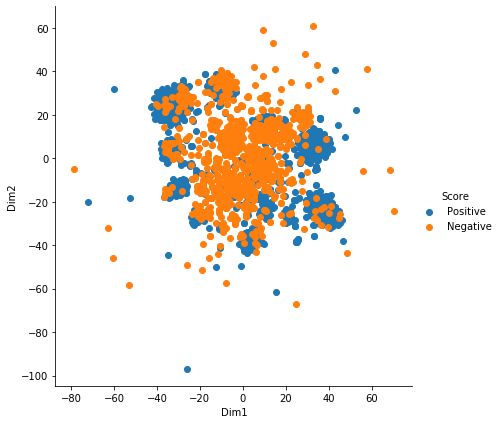

In [199]:
import matplotlib.pyplot as plt
tsne_df = pd.DataFrame(data=tsne_label,columns=('Dim1','Dim2','Score'))
tsne_df.head()
sb.FacetGrid(tsne_df,hue='Score',height=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

In [ ]:
KNN on Amazon Dataset:

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
con = sqlite3.connect("D:/Data_Practice/final.sqlite")

processed_data = pd.read_sql_query('''SELECT * FROM Reviews''',con)
processed_data.shape
processed_data.head()

final_pos = processed_data[processed_data.Score=='Positive']
final_pos.shape

final_neg = processed_data[processed_data.Score=='Negative']
final_neg.shape

final_pos_5000 = final_pos[0:8000]
#[0:5000]
final_pos_5000.shape
print(final_pos_5000.head(5))

final_neg_5000 = final_neg[0:8000]
#[0:5000]
final_neg_5000.shape
print(final_neg_5000.head(5))

final_10000 = pd.concat([final_pos_5000 , final_neg_5000],axis=0,ignore_index=True)
final_10000.tail()

sample = final_10000.sort_values(by='Time')
score_10000 = sample['Score']
sample.head()
sample['Score'].value_counts()



    index      Id   ProductId          UserId                  ProfileName  \
0  138706  150524  0006641040   ACITT7DI6IDDL              shari zychinski   
1  138688  150506  0006641040  A2IW4PEEKO2R0U                        Tracy   
2  138689  150507  0006641040  A1S4A3IQ2MU7V4        sally sue "sally sue"   
3  138690  150508  0006641040     AZGXZ2UUK6X  Catherine Hallberg "(Kate)"   
4  138691  150509  0006641040  A3CMRKGE0P909G                       Teresa   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     0                       0  Positive   939340800   
1                     1                       1  Positive  1194739200   
2                     1                       1  Positive  1191456000   
3                     1                       1  Positive  1076025600   
4                     3                       4  Positive  1018396800   

                                      Summary  \
0                   EVERY book is education

Positive    8000
Negative    8000
Name: Score, dtype: int64

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
count_vect = TfidfVectorizer(ngram_range=(1,2))
final_bow = count_vect.fit_transform(sample['Cleaned_Text'].values)
print(final_bow)

  (0, 193047)	0.13932118967792173
  (0, 253999)	0.13932118967792173
  (0, 217)	0.13932118967792173
  (0, 296986)	0.12184528146471815
  (0, 288922)	0.13932118967792173
  (0, 28436)	0.13932118967792173
  (0, 348276)	0.1265390328537347
  (0, 34140)	0.13932118967792173
  (0, 58483)	0.13932118967792173
  (0, 280665)	0.13932118967792173
  (0, 159776)	0.13932118967792173
  (0, 34073)	0.13366499517732486
  (0, 350549)	0.13366499517732486
  (0, 207182)	0.13932118967792173
  (0, 183364)	0.11554013776642218
  (0, 92429)	0.13932118967792173
  (0, 155935)	0.13932118967792173
  (0, 346587)	0.13932118967792173
  (0, 170984)	0.13932118967792173
  (0, 255410)	0.13932118967792173
  (0, 281881)	0.13932118967792173
  (0, 9279)	0.13932118967792173
  (0, 7159)	0.13932118967792173
  (0, 92317)	0.13932118967792173
  (0, 47191)	0.13932118967792173
  :	:
  (15999, 281256)	0.034932233026065435
  (15999, 233069)	0.056807481756657466
  (15999, 132873)	0.04677170121612898
  (15999, 322571)	0.042435224779580866
  (1

In [20]:
#Avg w2v 
avg_w2v = []
for sent in tqdm(sample['Cleaned_Text']):
    avg_w2v_ = np.zeros(200)
    cnt=1
    for w in sent:
        try:
            vec = w2v_model.wv[w]
            avg_w2v_ = avg_w2v_ + vec
            cnt+=1
        except:
            pass
    avg_w2v_=avg_w2v_/cnt
    avg_w2v.append(avg_w2v_)

    

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:21<00:00, 4758.19it/s]


In [127]:
avg_w2v=np.array(avg_w2v)
print(avg_w2v)

[[-0.12021854  0.21959213 -0.05145993 ...  0.26061566  0.4635529
  -0.16725331]
 [-0.28290466  0.29014108 -0.37541864 ...  0.32374343  0.57802602
  -0.07880948]
 [-0.12905339  0.41658082 -0.40995081 ...  0.25216171  0.1819254
  -0.22253546]
 ...
 [-0.01434231  0.12125124  0.37306224 ... -0.16115582  0.00689457
  -0.03442528]
 [-0.43213339  0.59693775 -0.22300815 ...  0.36029519  0.30937419
  -0.42564267]
 [-0.23762599  0.42907504 -0.39285999 ...  0.37969359  0.24513947
   0.14071821]]


In [103]:
#Dim Red is optional
from sklearn.manifold import TSNE
model = TSNE(n_components=3,random_state=0)
tsne_data = model.fit_transform(final_tfidf)
tsne_data.shape

(10000, 3)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score

X = final_bow  #We give entire dim without tSNE here
Y = score_10000

x_1,x_test,y_1,y_test = train_test_split(X,Y,test_size=0.3,random_state=10)#70 - 30
x_tr,x_cv,y_tr,y_cv   = train_test_split(x_1,y_1,test_size=0.3,random_state=10) # 70% of 70-->x_tr;30% of 70 -->x_cv/y_cv
#x_tr = 73,x_cv=32,x_test=45 and same y's also
#Now we find best K with best Acc



In [35]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
k_lst=[]
acc_lst=[]
for i in range(1,32):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_tr,y_tr)
    pred = knn.predict(x_tr)
    acc = accuracy_score(y_tr,pred,normalize=True)*float(100)
    k_lst.append(i)
    acc_lst.append(acc)
    print("Acc for k=%d is %d" %(i,acc))

Acc for k=1 is 100
Acc for k=2 is 86
Acc for k=3 is 88
Acc for k=4 is 84
Acc for k=5 is 85
Acc for k=6 is 83
Acc for k=7 is 83
Acc for k=8 is 82
Acc for k=9 is 83
Acc for k=10 is 82
Acc for k=11 is 82
Acc for k=12 is 83
Acc for k=13 is 82
Acc for k=14 is 82
Acc for k=15 is 82
Acc for k=16 is 82
Acc for k=17 is 82
Acc for k=18 is 82
Acc for k=19 is 82
Acc for k=20 is 81
Acc for k=21 is 81
Acc for k=22 is 81
Acc for k=23 is 81
Acc for k=24 is 81
Acc for k=25 is 81
Acc for k=26 is 81
Acc for k=27 is 81
Acc for k=28 is 81
Acc for k=29 is 81
Acc for k=30 is 81
Acc for k=31 is 81


In [36]:
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
k1_lst=[]
acc1_lst=[]
for i in range(1,32):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_tr,y_tr)
    pred = knn.predict(x_cv)
    acc = accuracy_score(y_cv,pred,normalize=True)*float(100)
    k1_lst.append(i)
    acc1_lst.append(acc)
    
    print("Acc for k=%d is %d" %(i,acc))

Acc for k=1 is 72
Acc for k=2 is 69
Acc for k=3 is 75
Acc for k=4 is 74
Acc for k=5 is 77
Acc for k=6 is 76
Acc for k=7 is 77
Acc for k=8 is 77
Acc for k=9 is 79
Acc for k=10 is 78
Acc for k=11 is 79
Acc for k=12 is 79
Acc for k=13 is 79
Acc for k=14 is 79
Acc for k=15 is 79
Acc for k=16 is 79
Acc for k=17 is 78
Acc for k=18 is 79
Acc for k=19 is 79
Acc for k=20 is 79
Acc for k=21 is 80
Acc for k=22 is 80
Acc for k=23 is 80
Acc for k=24 is 80
Acc for k=25 is 80
Acc for k=26 is 80
Acc for k=27 is 80
Acc for k=28 is 80
Acc for k=29 is 80
Acc for k=30 is 80
Acc for k=31 is 80


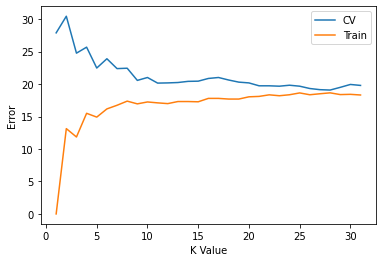

In [45]:
import matplotlib.pyplot as plt
import seaborn as sb
acc_lst=[100-i for i in acc_lst]
acc1_lst=[100-i for i in acc1_lst]
plt.plot(k1_lst,acc1_lst)
plt.plot(k_lst,acc_lst)
plt.xlabel("K Value")
plt.ylabel("Error")
plt.legend(["CV","Train"])
plt.show()

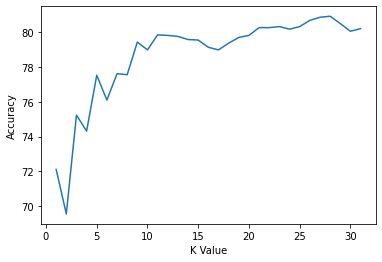

In [39]:
import matplotlib.pyplot as plt
import seaborn as sb
acc1_lst=[100-i for i in acc1_lst]
plt.plot(k1_lst,acc1_lst)
plt.xlabel("K Value")
plt.ylabel("Accuracy")
plt.show()

In [14]:
knn=KNeighborsClassifier(n_neighbors=10)
knn.fit(x_tr,y_tr)
pred = knn.predict(x_test)
print(pred + "  "  + y_test) 
acc = accuracy_score(y_test,pred)*100
print(acc)

13605    Negative  Negative
4300     Negative  Positive
3037     Positive  Positive
2670     Positive  Positive
3201     Positive  Positive
                ...        
14999    Negative  Negative
14484    Negative  Negative
9576     Negative  Negative
2475     Positive  Positive
12239    Negative  Negative
Name: Score, Length: 4800, dtype: object
77.45833333333333


In [16]:
import numpy as np
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
alpha_val = [{'alpha':np.arange(0,3,0.2)}]
model = GridSearchCV(BernoulliNB(),alpha_val,scoring='accuracy')
model.fit(x_tr,y_tr)
print(model.best_estimator_)
print(model.score(x_cv,y_cv))

C:\Users\kiran\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kiran\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kiran\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kiran\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\naive_bayes.py:512: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\Users\kiran\AppData\Local\Programs\Python\Python36\lib\site-packages\sklearn\naive_bayes.py:512: UserWarn

BernoulliNB(alpha=0.2)
0.8636904761904762


In [21]:
clf = BernoulliNB(alpha=0.5)
clf.fit(x_tr,y_tr)
pred = clf.predict(x_test)

print(y_test + " " + pred) 
acc = accuracy_score(y_test,pred)*100
print(acc)


13605    Negative Negative
4300     Positive Negative
3037     Positive Positive
2670     Positive Positive
3201     Positive Positive
               ...        
14999    Negative Negative
14484    Negative Negative
9576     Negative Negative
2475     Positive Positive
12239    Negative Negative
Name: Score, Length: 4800, dtype: object
86.02083333333333
